## Week 12 Homework (10)

### Q1: define

- Gaussian Processes (GPs) and stochastic processes generally
- Variational inference using the Evidence Lower Bound (ELBO)

### Q2: more GPs

Repurpose PyMC documentation to provide a demonstration of Gaussian processes for a different dataset context than the PyMC examples.

### Q3: more VI/ELBO

Repurpose PyMC documentation to provide a demonstration of a neural network fit with variational inference for a different dataset context than the PyMC examples.



Q1

Gaussian Processes (GPs) and Stochastic Processes:

A Gaussian Process is a collection of random variables, any finite subset of which follows a joint Gaussian distribution. It is fully characterized by a mean function and a covariance function.

A stochastic process is a family of random variables indexed over time. It models systems change randomly, capturing uncertainty and variability in dynamic processes.

Variational Inference using the Evidence Lower Bound (ELBO):

Variational inference is an approximate Bayesian inference technique that replaces complex posterior distributions with simpler, tractable ones. The Evidence Lower Bound (ELBO) is the objective function used in this optimization—it serves as a lower bound to the log marginal likelihood (evidence) of the data. By maximizing the ELBO, the divergence between the true posterior and the approximating distribution is minimized, leading to an effective approximation of the original intractable posterior.

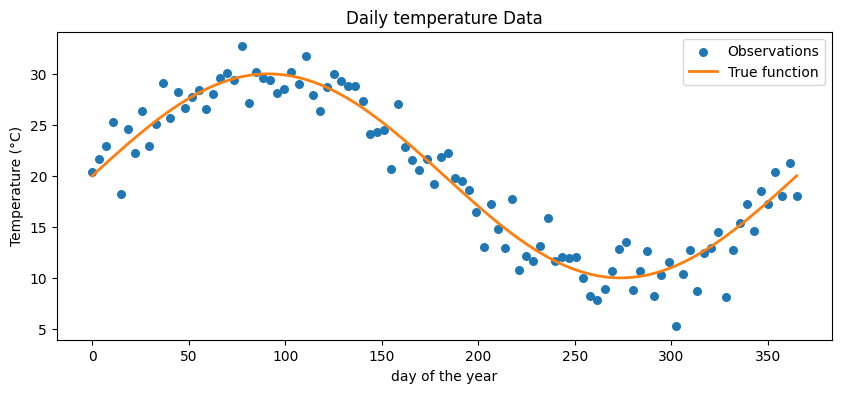

/usr/local/lib/python3.11/dist-packages/pymc/gp/gp.py:55: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


Output()

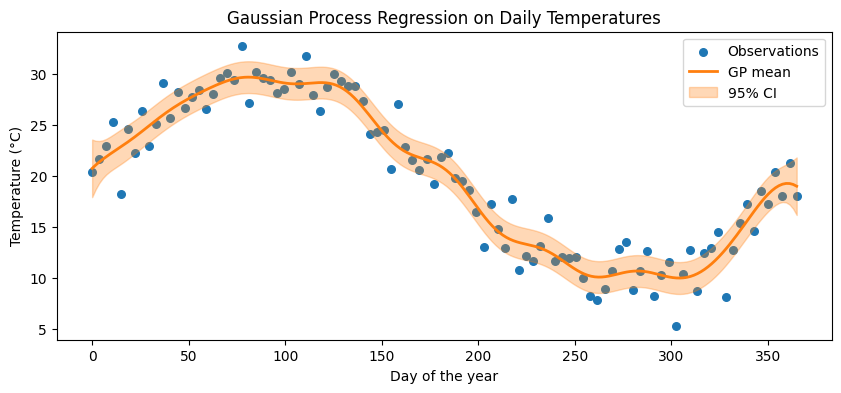

In [2]:
#Q2
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

np.random.seed(365)

# Create a fake dataset that is about daily temps
n_samples = 100
x = np.linspace(0, 365, n_samples)

true_amplitude = 10.0
true_baseline = 20.0
true_period = 365.0
noise_std = 2.0

y_true = true_baseline + true_amplitude * np.sin(2 * np.pi * x / true_period)
y = y_true + np.random.normal(0, noise_std, size=n_samples)


plt.figure(figsize=(10, 4))
plt.scatter(x, y, c='C0', label="Observations", s=30)
plt.plot(x, y_true, c='C1', lw=2, label="True function")
plt.xlabel("day of the year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.title("Daily temperature Data")
plt.show()


with pm.Model() as model:
    ls = pm.Gamma("ls", alpha=2, beta=1)
    amp = pm.HalfNormal("amp", sigma=10)
    cov = amp ** 2 * pm.gp.cov.ExpQuad(1, ls)

    sigma = pm.HalfNormal("sigma", sigma=5)
    gp = pm.gp.Marginal(cov_func=cov)
    y_obs = gp.marginal_likelihood("y_obs", X=x[:, None], y=y, noise=sigma)
    map_estimate = pm.find_MAP()

    x_pred = np.linspace(0, 365, 200)[:, None]
    mu, var = gp.predict(x_pred, point=map_estimate, diag=True)
    sd = np.sqrt(var)

plt.figure(figsize=(10, 4))
plt.scatter(x, y, c='C0', label="Observations", s=30)
plt.plot(x_pred, mu, c='C1', lw=2, label="GP mean")
plt.fill_between(x_pred.flatten(), mu - 2*sd, mu + 2*sd, color='C1', alpha=0.3, label="95% CI")
plt.xlabel("Day of the year")
plt.ylabel("Temperature (°C)")
plt.title("Gaussian Process Regression on Daily Temperatures")
plt.legend()
plt.show()


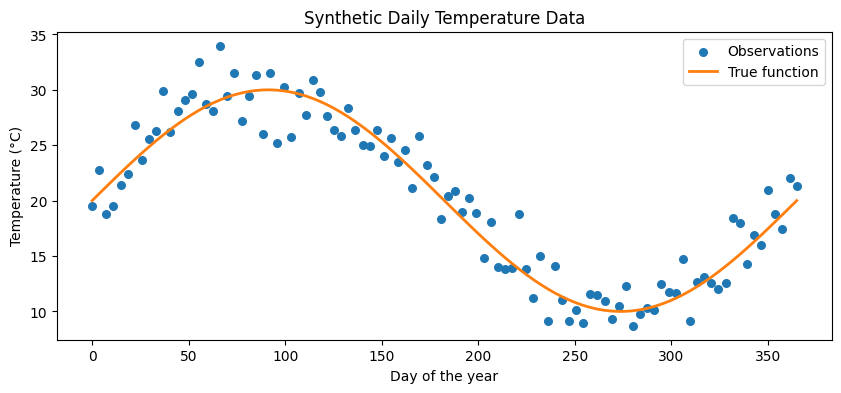

Output()

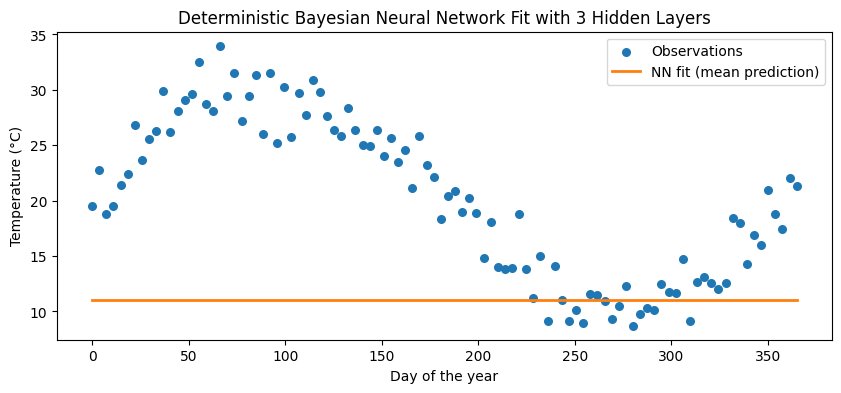

In [9]:


# Generate synthetic daily temperature data
n_samples = 100
x = np.linspace(0, 365, n_samples)[:, None]
# Scale inputs to [0, 1] to help with the activation functions
x_scaled = x / 365.0

true_amplitude = 10.0
true_baseline = 20.0
true_period = 365.0
noise_std = 2.0

y_true = true_baseline + true_amplitude * np.sin(2 * np.pi * x.flatten() / true_period)
y = y_true + np.random.normal(0, noise_std, size=n_samples)

# Plot the synthetic data with the true function
plt.figure(figsize=(10, 4))
plt.scatter(x, y, c='C0', label="Observations", s=30)
plt.plot(x, y_true, c='C1', lw=2, label="True function")
plt.xlabel("Day of the year")
plt.ylabel("Temperature (°C)")
plt.title("Synthetic Daily Temperature Data")
plt.legend()
plt.show()

# Define the Bayesian Neural Network with three hidden layers using scaled inputs
n_hidden1 = 10
n_hidden2 = 10
n_hidden3 = 10

with pm.Model() as nn_model:
    # First hidden layer
    W1 = pm.Normal("W1", mu=0, sigma=1, shape=(n_hidden1, 1))
    b1 = pm.Normal("b1", mu=0, sigma=1, shape=(n_hidden1,))
    hidden1 = pm.math.tanh(pm.math.dot(x_scaled, W1.T) + b1)

    # Second hidden layer
    W2 = pm.Normal("W2", mu=0, sigma=1, shape=(n_hidden2, n_hidden1))
    b2 = pm.Normal("b2", mu=0, sigma=1, shape=(n_hidden2,))
    hidden2 = pm.math.tanh(pm.math.dot(hidden1, W2.T) + b2)

    # Third hidden layer
    W3 = pm.Normal("W3", mu=0, sigma=1, shape=(n_hidden3, n_hidden2))
    b3 = pm.Normal("b3", mu=0, sigma=1, shape=(n_hidden3,))
    hidden3 = pm.math.tanh(pm.math.dot(hidden2, W3.T) + b3)

    # Output layer
    W4 = pm.Normal("W4", mu=0, sigma=1, shape=(n_hidden3, 1))
    b4 = pm.Normal("b4", mu=0, sigma=1)
    mu_nn = pm.math.dot(hidden3, W4) + b4

    sigma = pm.HalfNormal("sigma", sigma=5)
    y_obs = pm.Normal("y_obs", mu=mu_nn.flatten(), sigma=sigma, observed=y)

    # Specify small random starting values for the mus (weights and biases)
    start_vals = {
        "W1": np.random.randn(n_hidden1, 1) * 0.01,
        "b1": np.random.randn(n_hidden1) * 0.01,
        "W2": np.random.randn(n_hidden2, n_hidden1) * 0.01,
        "b2": np.random.randn(n_hidden2) * 0.01,
        "W3": np.random.randn(n_hidden3, n_hidden2) * 0.01,
        "b3": np.random.randn(n_hidden3) * 0.01,
        "W4": np.random.randn(n_hidden3, 1) * 0.01,
        "b4": np.random.randn() * 0.01,
        "sigma": 1.0
    }

    # Increase ADVI iterations and use the custom starting values
    approx = pm.fit(n=100000, method='advi', start=start_vals)
    trace = approx.sample(1000)

# Extract the posterior mean for each parameter for deterministic predictions
W1_mean = trace.posterior["W1"].values.mean(axis=(0, 1))
b1_mean = trace.posterior["b1"].values.mean(axis=(0, 1))
W2_mean = trace.posterior["W2"].values.mean(axis=(0, 1))
b2_mean = trace.posterior["b2"].values.mean(axis=(0, 1))
W3_mean = trace.posterior["W3"].values.mean(axis=(0, 1))
b3_mean = trace.posterior["b3"].values.mean(axis=(0, 1))
W4_mean = trace.posterior["W4"].values.mean(axis=(0, 1))
b4_mean = trace.posterior["b4"].values.mean(axis=(0, 1))

# Make predictions using scaled inputs for the deterministic NN
x_pred = np.linspace(0, 365, 200)[:, None]
x_pred_scaled = x_pred / 365.0

hidden1_pred = np.tanh(np.dot(x_pred_scaled, W1_mean.T) + b1_mean)
hidden2_pred = np.tanh(np.dot(hidden1_pred, W2_mean.T) + b2_mean)
hidden3_pred = np.tanh(np.dot(hidden2_pred, W3_mean.T) + b3_mean)
mu_pred = np.dot(hidden3_pred, W4_mean) + b4_mean

# Plot the NN fit against the observations
plt.figure(figsize=(10, 4))
plt.scatter(x, y, c='C0', label="Observations", s=30)
plt.plot(x_pred, mu_pred, c='C1', lw=2, label="NN fit (mean prediction)")
plt.xlabel("Day of the year")
plt.ylabel("Temperature (°C)")
plt.title("Deterministic Bayesian Neural Network Fit with 3 Hidden Layers")
plt.legend()
plt.show()
